In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

In [2]:
house = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_2_Processed_TimeSeries.csv')
house2 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_3_Processed_TimeSeries.csv')
house3 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_4_Processed_TimeSeries.csv')
states = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/state_appliance_combinations.csv')
house2.head(5)

,Unnamed: 0,Time,Temperature,PV_V,Digit,Battery_V,Digit2,PV_Current,Battery_Current,PV_Current_Adj,Battery_Current_Adj,PV_Power,Battery_Power,Load,Load_Corrected,Solar_Irradiance,Spillage
0,0,2015-06-23 12:28:00,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240,603.149077,606.887860,-2.094952,-1.191036,-3.285988,0.000000,-31.480545,0.000000
1,1,2015-06-23 12:29:00,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240,603.148727,606.887860,-1.800913,-1.190112,-2.991025,0.000000,-27.062072,0.000000
2,2,2015-06-23 12:30:00,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544,603.148027,606.887176,-1.071425,-0.714067,-1.785492,0.000000,-16.100148,0.000000
3,3,2015-06-23 12:31:00,30.43,13.30,32760,12.80,32750,0.209077,0.44352,603.143130,606.877935,2.780724,5.677056,8.457780,8.457780,41.785553,8.457780
4,4,2015-06-23 12:32:00,30.42,13.23,32766,12.75,32745,0.095035,0.53592,603.145229,606.876224,1.257313,6.832980,8.090293,8.090293,18.893468,8.090293


In [3]:
states.head(10)

,State,Expected_Mean_Power,Appliance_Combination
0,1,0,None
1,2,9,1_CFL
2,3,14,1_Fan
3,4,18,2_CFL
4,5,23,1_Fan_1_CFL
5,6,27,3_CFL
6,7,32,2_CFL_1_Fan
7,8,36,4_CFL
8,9,41,3_CFL_1_Fan
9,10,50,4_CFL_1_Fan


In [4]:
# Define functions

def conditions(x):
    if x == 0:
        return '1'
    elif x > 0 and x <= 9:
        return '2'
    elif x > 9 and x <= 14:
        return '3'
    elif x > 14 and x <=18:
        return '4'
    elif x > 18 and x <=23:
        return '5'
    elif x > 23 and x <=27:
        return '6'
    elif x > 27 and x <=32:
        return '7'
    elif x > 32 and x <= 36:
        return '8'
    elif x > 36 and x <= 41:
        return '9'
    else:
        return '10'
    

def data_processing(data):
    func = np.vectorize(conditions)
    energy_class = func(data['Load_Corrected'])
    data['State'] = energy_class
    return data

def data_plot(data, name):
    plt.figure(figsize=(16,10))
    data['State'].value_counts().plot(kind='bar')
    plt.title("%s: Frequency of States" % name)
    plt.xlabel("State")
    plt.ylabel("Count")
    plt.show()
    data['State'] = data['State'].astype('int64')
    data.plot(x='State', y='Load_Corrected', kind='scatter')
    plt.show()




(319756, 18)
(319684, 18)
(319713, 18)


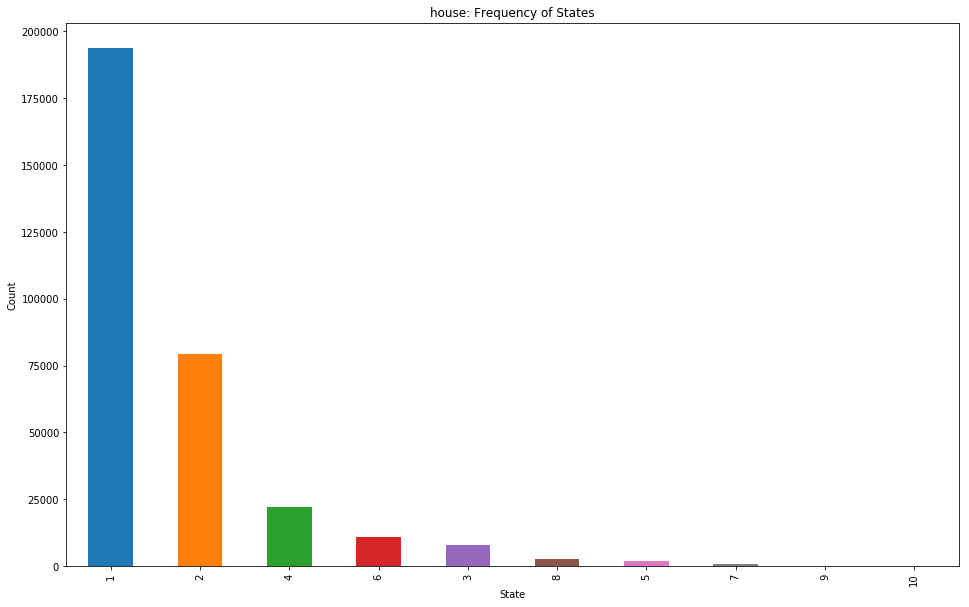

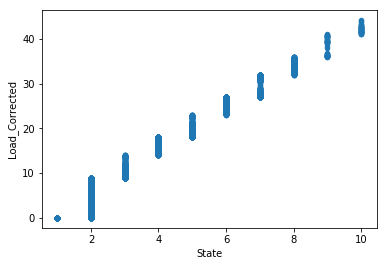

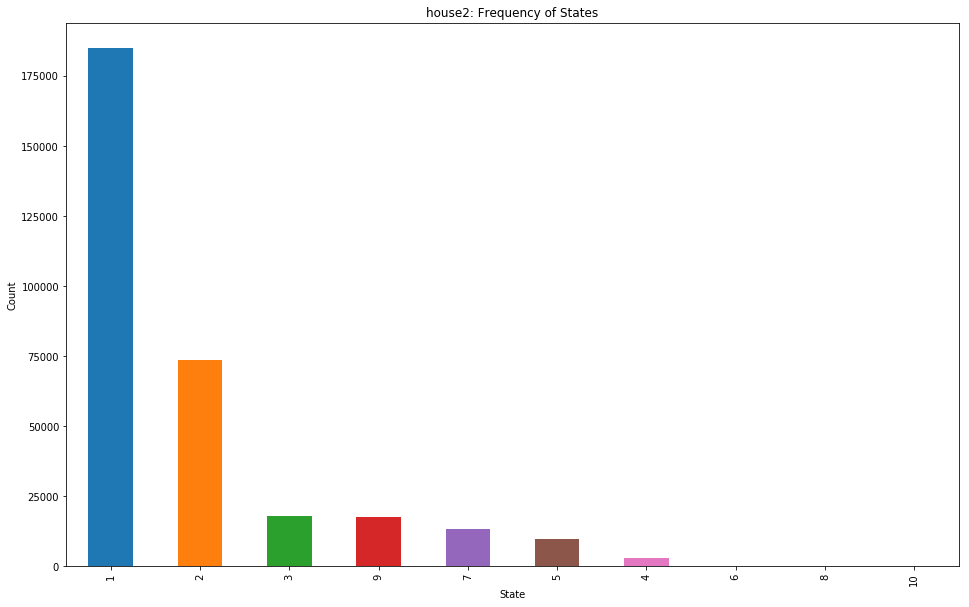

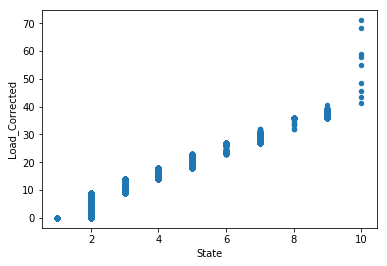

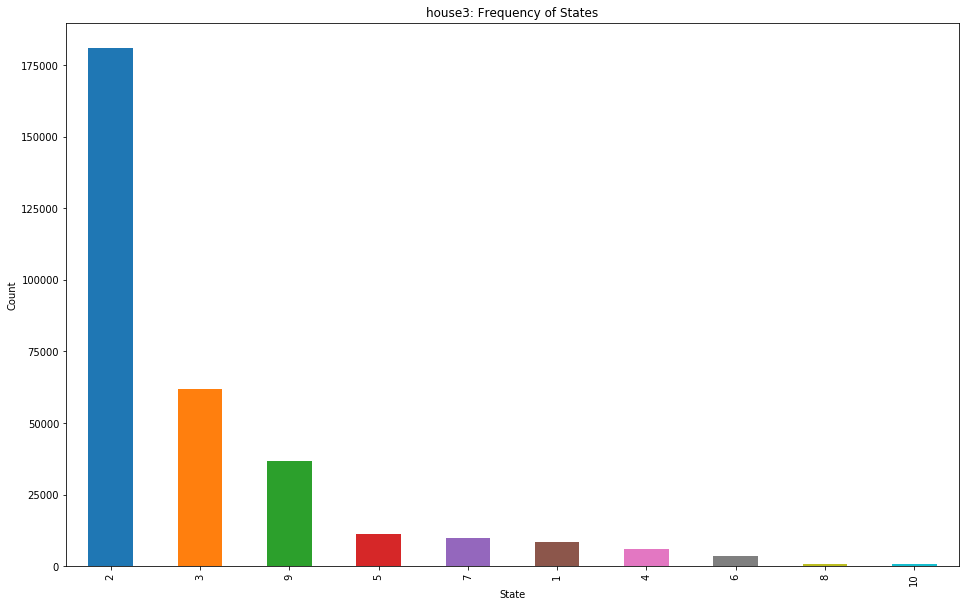

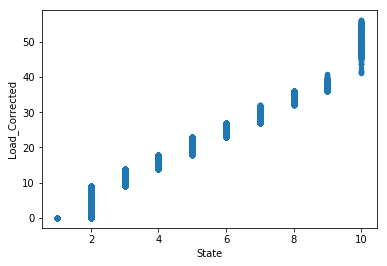

In [5]:
house = data_processing(house)
house2 = data_processing(house2)
house3 = data_processing(house3)

print(house.shape)
print(house2.shape)
print(house3.shape)

data_plot(house, 'house')
data_plot(house2, 'house2')
data_plot(house3, 'house3')

## KMeans Clustering Models

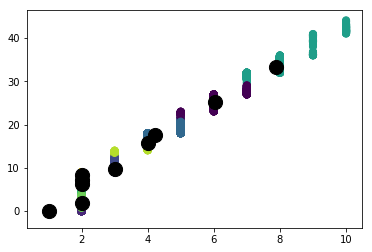

In [6]:
# fit Kmeans
states_load = house.loc[:,['State','Load_Corrected']]
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

# Plot clusters
plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:, 1], c='black', s=200, alpha=1)

### State initialisation

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


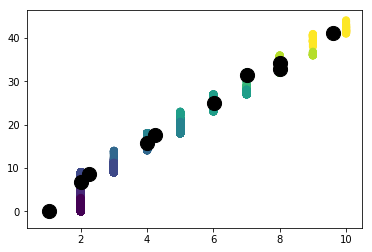

In [7]:
## Initialise cluster centers with averages for each state

temp = states_load.groupby('State')['Load_Corrected'].mean()
temp_ar = np.array(temp)
states = [1,2,3,4,5,6,7,8,9,10]
averaged = np.column_stack((states,temp))

# fit Kmeans
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10, init=averaged)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)

### Scale variables and compare initialisation method accuracy 

In [8]:
scaled = StandardScaler()
states_scaled = scaled.fit_transform(X)
states = states_load['State']
states_scaled = np.column_stack((states,states_scaled))

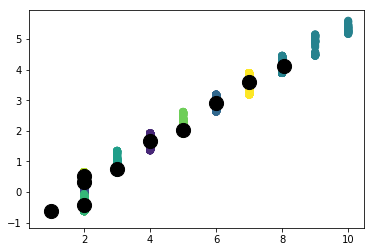

In [9]:
# Cluster
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_scaled)
y_kmeans = kmeans.predict(states_scaled)

plt.scatter(states_scaled[:,0], states_scaled[:,1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of KMeans with [[ 1.          0.        ]
 [ 2.          6.71036356]
 [ 3.          9.66841154]
 [ 4.         16.29018343]
 [ 5.         18.87594505]
 [ 6.         25.06220111]
 [ 7.         30.00689768]
 [ 8.         33.32743651]
 [ 9.         38.3894043 ]
 [10.         42.15167598]] init


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of KMeans with [[ 1.          0.        ]
 [ 2.          6.71036356]
 [ 3.          9.66841154]
 [ 4.         16.29018343]
 [ 5.         18.87594505]
 [ 6.         25.06220111]
 [ 7.         30.00689768]
 [ 8.         33.32743651]
 [ 9.         38.3894043 ]
 [10.         42.15167598]] init


Text(0.5,0,'Initialisation')

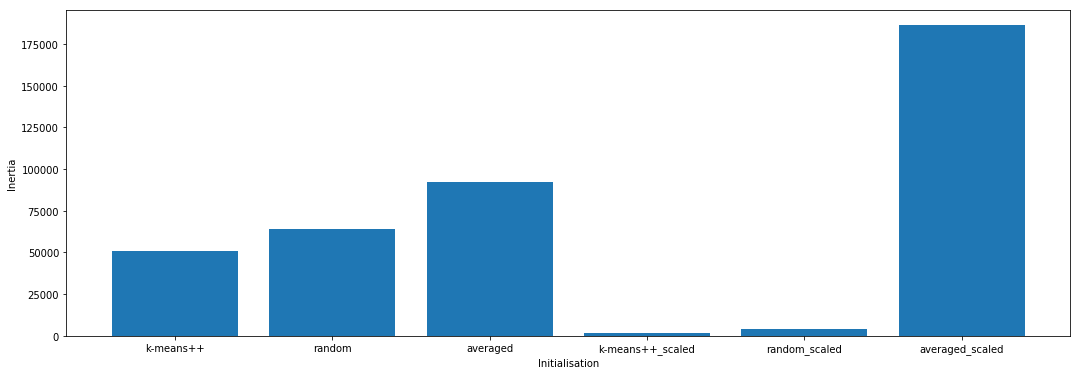

In [10]:
## Compare methods of initialisation with KMeans, Random, and a dictionary with cluster center initialisation using calculated means

cases = [
    (KMeans, 1,'k-means++', {}),
    (KMeans,2, 'random', {}),
    (KMeans,3, averaged, {})
]
n_clusters = 10


# Inertia is defined as the sum of squared distances to the nearest cluster center
inertia = {}

# Regular data set
for factory, i, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    km = factory(n_clusters, init=init, **params).fit(states_load)
    if i == 3:
        init = 'averaged'
        inertia[init] = km.inertia_       
    else:
        inertia[init] = km.inertia_

# Scaled data set 
for factory, i, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    km = factory(n_clusters, init=init, **params).fit(states_scaled)
    if i == 3:
        init = 'averaged'
        init = init + '_scaled'
        inertia[init] = km.inertia_       
    else:
        init = init + '_scaled'
        inertia[init] = km.inertia_
        
# Plot comparison 

plt.figure(figsize=(18,6))
plt.bar(range(len(inertia)), list(inertia.values()))
plt.xticks(range(len(inertia)), list(inertia.keys()))
plt.ylabel('Inertia')
plt.xlabel('Initialisation')
    

## Gaussian Mixture Models

Text(0.5,0,'n_components')

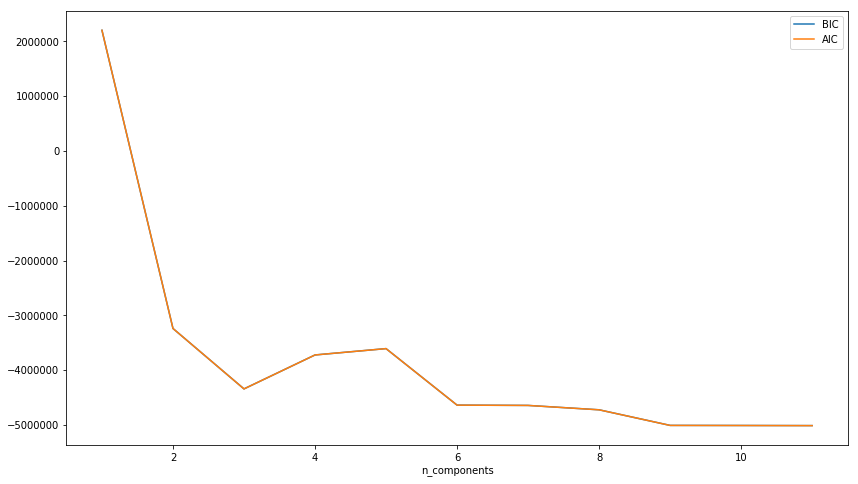

In [11]:
## Plot BIC and AIC for a range of components using scaled data set 

n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(states_load)
          for n in n_components]

plt.figure(figsize=(14,8))
plt.plot(n_components, [m.bic(states_load) for m in models], label='BIC')
plt.plot(n_components, [m.aic(states_load) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

### Unscaled and scaled variables

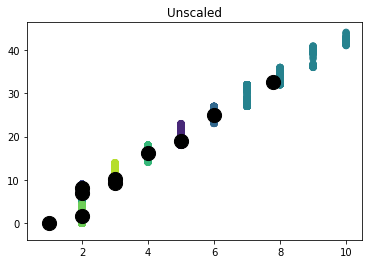

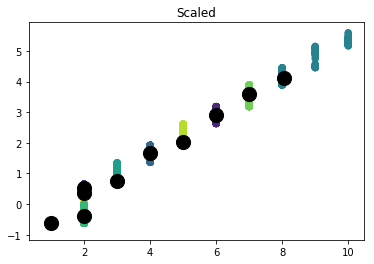

In [12]:
gmm = GaussianMixture(n_components=10).fit(states_load)
centers = gmm.means_
labels = gmm.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=labels, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)
plt.title("Unscaled")
plt.show()

### Scaled variables 

gmm = GaussianMixture(n_components=10).fit(states_scaled)
centers = gmm.means_
labels = gmm.predict(states_scaled)

plt.scatter(states_scaled[:,0], states_scaled[:,1], c=labels, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)
plt.title("Scaled")
plt.show()

### State initialisation

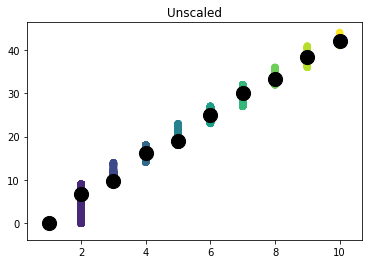

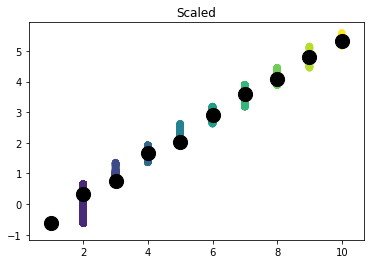

In [16]:
### Unscaled and scaled variables with mean initialisation

states = [1,2,3,4,5,6,7,8,9,10]

def calc_avg(data):
    averages = data.groupby('State')['Load_Corrected'].mean()
    av_arr = np.array(averages)
    averaged = np.column_stack((states, av_arr))
    return averaged

# Unscaled

averages = calc_avg(states_load)

gmm = GaussianMixture(n_components=10, means_init=averages).fit(states_load)
centers_avg = gmm.means_
labels_avg = gmm.predict(states_load)

# Scaled
states_scaled_avg = pd.DataFrame(states_scaled)
columns = ['State', 'Load_Corrected']
states_scaled_avg.columns = columns

averages_scaled = calc_avg(states_scaled_avg)

gmm = GaussianMixture(n_components=10, means_init=averages_scaled).fit(states_scaled_avg)
centers_avg_scaled = gmm.means_
labels_avg_scaled = gmm.predict(states_scaled_avg)


plt.scatter(states_load.loc[:, 'State'], states_load.loc[:,'Load_Corrected'], c=labels_avg, s=40, cmap='viridis')
plt.title("Unscaled")
plt.scatter(centers_avg[:, 0], centers_avg[:, 1], c='black', s=200, alpha=1)
plt.show()

plt.scatter(states_scaled_avg.loc[:, 'State'], states_scaled_avg.loc[:,'Load_Corrected'], c=labels_avg_scaled, s=40, cmap='viridis')
plt.title("Scaled")
plt.scatter(centers_avg_scaled[:, 0], centers_avg_scaled[:, 1], c='black', s=200, alpha=1)
plt.show()

## Prediction for other house data sets

In [17]:
# define some functions 

def arrange(data):
    states_load = data.loc[:, ['State', 'Load_Corrected']]
    return states_load

def calc_avg(data):
    averages = data.groupby('State')['Load_Corrected'].mean()
    av_arr = np.array(averages)
    averaged = np.column_stack((states, av_arr))
    return averaged

def scale_data(data):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)
    return scaled 

def scatter_plot(data, labels, centers):
    plt.scatter(data.loc[:, 'State'], data.loc[:,'Load_Corrected'], c=labels, s=40, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)
    plt.show()
    


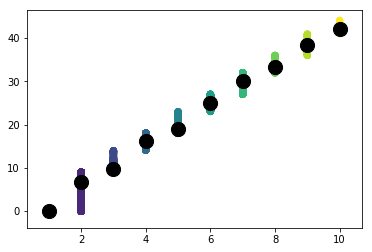

In [18]:
# Train model on house 1 data set

states_load = arrange(house)
averages = calc_avg(states_load)

gmm = GaussianMixture(n_components=10, means_init=averages).fit(states_load)
centers_avg = gmm.means_
labels_avg = gmm.predict(states_load)
scatter_plot(house, labels_avg, centers_avg)

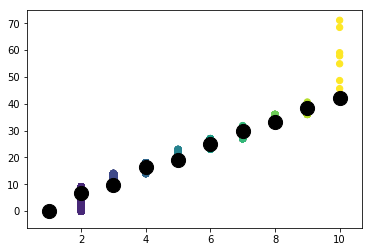

In [19]:
# Test model on house 2 data set

states_load2 = arrange(house2)
labels_house2 = gmm.predict(states_load2)
centers_house2 = gmm.means_
scatter_plot(house2, labels_house2, centers_house2)

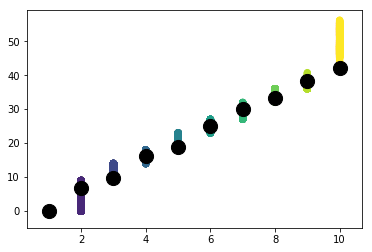

In [20]:
# Test model on house 3 data set

states_load3 = arrange(house3)
labels_house3 = gmm.predict(states_load3)
centers_house3 = gmm.means_
scatter_plot(house3, labels_house3, centers_house3)